<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/hire_4%2Bindices%2B%5Bdsm%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rasterio

In [ ]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# Load RGB image
rgb = rasterio.open("/content/RGB.tif")

# Load habitat map (vector)
habitat = gpd.read_file("/content/Ballymore_habitat_map2018_ITM.shp")

In [ ]:
# Reproject habitat to match RGB CRS
habitat = habitat.to_crs(rgb.crs)

In [ ]:
out_image, out_transform = mask(rgb, habitat.geometry, crop=True)

In [ ]:
out_meta = rgb.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

In [ ]:
with rasterio.open("clipped_rgb.tif", "w", **out_meta) as dest:
    dest.write(out_image)

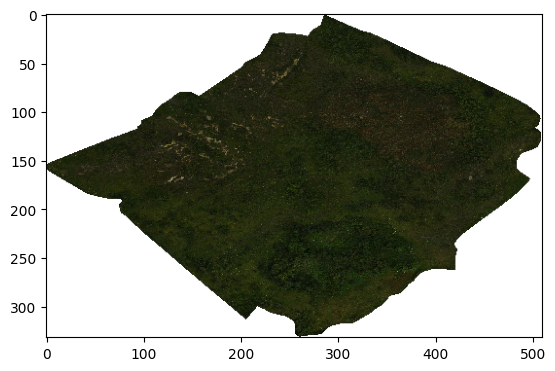

In [ ]:
import matplotlib.pyplot as plt

with rasterio.open("clipped_rgb.tif") as src:
    plt.imshow(src.read().transpose((1, 2, 0)))
    plt.show()

In [ ]:
# Load habitat vector
habitat = gpd.read_file("/content/Ballymore_habitat_map2018_ITM.shp")

# Load raster to get CRS
with rasterio.open("clipped_rgb.tif") as src:
    raster_crs = src.crs
    profile = src.profile
    transform = src.transform
    shape = (src.height, src.width)
    img = src.read()  # shape: (bands, rows, cols)

# Reproject habitat to raster CRS
if habitat.crs != raster_crs:
    habitat = habitat.to_crs(raster_crs)
    print("Reprojected habitat shapefile to match raster CRS.")
else:
    print("CRS already matches.")

Reprojected habitat shapefile to match raster CRS.


In [ ]:
if habitat.crs != raster_crs:
    habitat = habitat.to_crs(raster_crs)
    print("Reprojected habitat shapefile to match raster CRS.")
else:
    print("CRS already matches.")

CRS already matches.


In [ ]:
class_names = [
    "Transition mire and quaking bog",
    "Rich fen and flush",
    "Rich fen and flush/Transition mire and quaking bog",
    "Raised bog",
    "Marsh",
    "Scrub/Dry meadows and grassy verges",
    "Transition mire and quaking bog/Marsh",
    "Scrub/Cutover bog"
]

class_mapping = {name: i+1 for i, name in enumerate(class_names)}
habitat["class_id"] = habitat["FossittTyp"].map(class_mapping)

In [ ]:
habitat_raster = rasterize(
    [(geom, value) for geom, value in zip(habitat.geometry, habitat["class_id"])],
    out_shape=shape,
    transform=transform,
    fill=0,
    dtype="int32"
)

In [ ]:
n_bands, rows, cols = img.shape
X = img.reshape(n_bands, rows * cols).T
y_labels = habitat_raster.flatten()

mask = y_labels > 0
X = X[mask]
y_labels = y_labels[mask]

In [ ]:
Bogs = [
    "Transition mire and quaking bog",
    "Raised bog",
    "Rich fen and flush/Transition mire and quaking bog",
]

Fens = [
    "Rich fen and flush",
]

Marshes = [
    "Marsh",
    "Transition mire and quaking bog/Marsh",
]
scrub_classes = [
    "Scrub/Dry meadows and grassy verges",
    "Scrub/Cutover bog"
]

bogs_ids = [class_mapping[c] for c in Bogs]
scrub_ids = [class_mapping[c] for c in scrub_classes]
fens_ids = [class_mapping[c] for c in Fens]
marshes_ids = [class_mapping[c] for c in Marshes]

broad_groups = np.where(np.isin(y_labels, bogs_ids), 1, # Group 1: Bogs
                        np.where(np.isin(y_labels, fens_ids), 2, # Group 2: Fens
                                 np.where(np.isin(y_labels, marshes_ids), 3, # Group 3: Marshes
                                          4))) # Group 4: Scrub/Other (default if not Bogs, Fens, or Marshes)

In [ ]:
print(Bogs)

print(Fens)

print(Marshes)

print(scrub_classes)

['Transition mire and quaking bog', 'Raised bog', 'Rich fen and flush/Transition mire and quaking bog']
['Rich fen and flush']
['Marsh', 'Transition mire and quaking bog/Marsh']
['Scrub/Dry meadows and grassy verges', 'Scrub/Cutover bog']


In [ ]:
Blue, Green, Red, NIR = X[:,0], X[:,1], X[:,2], X[:,3]

In [ ]:
NDVI = (NIR - Red) / (NIR + Red + 1e-10)
RVI = NIR / (Red + 1e-10)
SAVI = (1.5 * (NIR - Red)) / (NIR + Red + 0.5 + 1e-10)  # L=0.5
EVI = 2.5 * (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1)
GNDVI = (NIR - Green) / (NIR + Green + 1e-10)
GRVI = (Green - Red) / (Green + Red + 1e-10)
NRVI = ((Red / (NIR + 1e-10)) - 1) / ((Red / (NIR + 1e-10)) + 1)
NDWI = (Green - NIR) / (Green + NIR + 1e-10)

In [ ]:
#stack indices with features
X_with_indices = np.column_stack([
    X, NDVI, RVI, SAVI, EVI, GNDVI, GRVI, NRVI, NDWI
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_with_indices, broad_groups, test_size=0.3, random_state=42, stratify=broad_groups
)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.4341416806952091

Classification Report:
               precision    recall  f1-score   support

           1       0.65      0.44      0.53      8943
           2       0.17      0.37      0.23      2154
           3       0.47      0.48      0.47      6587
           4       0.36      0.38      0.37      4295

    accuracy                           0.43     21979
   macro avg       0.41      0.42      0.40     21979
weighted avg       0.49      0.43      0.45     21979


Confusion Matrix:
 [[3977 1448 2190 1328]
 [ 323  797  510  524]
 [1170 1228 3130 1059]
 [ 686 1157  814 1638]]


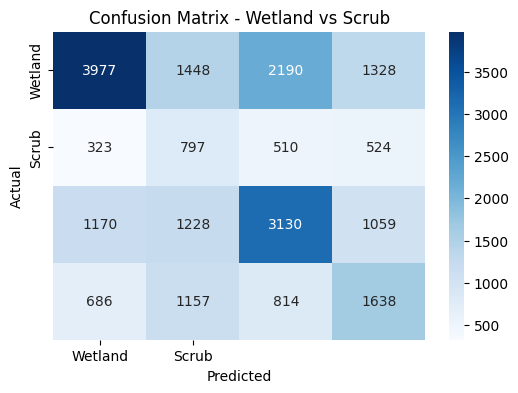

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Wetland","Scrub"],
            yticklabels=["Wetland","Scrub"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Wetland vs Scrub")
plt.show()

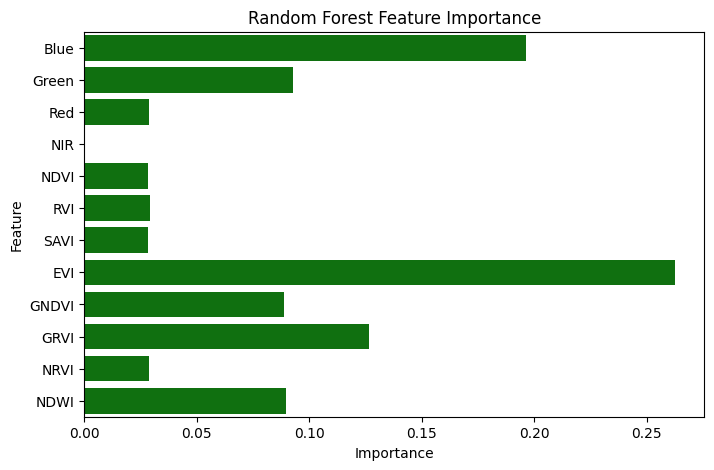

In [ ]:
import pandas as pd

# Define feature names based on X_with_indices structure
feature_names = [
    "Blue", "Green", "Red", "NIR",
    "NDVI", "RVI", "SAVI", "EVI",
    "GNDVI", "GRVI", "NRVI", "NDWI"
]

# Get feature importances from the trained Random Forest model
importances = rf.feature_importances_

# Create DataFrame for plotting
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

plt.figure(figsize=(8,5))
sns.barplot(data=feat_imp, x="Importance", y="Feature", color="green")
plt.title("Random Forest Feature Importance")
plt.show()

smote

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_with_indices, broad_groups, test_size=0.3, random_state=42, stratify=broad_groups
)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original training set shape:", np.bincount(y_train))
print("Resampled training set shape:", np.bincount(y_train_resampled))

Original training set shape: [    0 20866  5026 15368 10022]
Resampled training set shape: [    0 20866 20866 20866 20866]


SMOTE successfully balanced the classes by bringing all minority classes up to the count of the majority class (20866 in this case).

In [ ]:
rf = RandomForestClassifier(
    n_estimators=500, # Increased from 400
    max_depth=20,     # Added a max depth to prevent overfitting
    min_samples_leaf=5, # Added min samples per leaf
    random_state=42
)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=500,
                       random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.4608034942445061

Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.46      0.55      8943
           2       0.18      0.32      0.23      2154
           3       0.49      0.52      0.50      6587
           4       0.38      0.44      0.40      4295

    accuracy                           0.46     21979
   macro avg       0.43      0.44      0.42     21979
weighted avg       0.51      0.46      0.48     21979


Confusion Matrix:
 [[4113 1160 2290 1380]
 [ 311  695  535  613]
 [1034  984 3441 1128]
 [ 655  958  803 1879]]


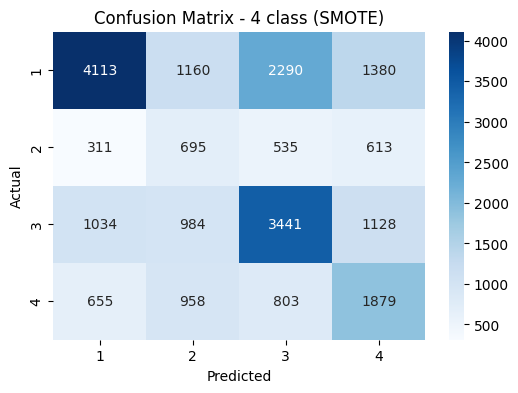

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["1","2",'3','4'],
            yticklabels=["1","2",'3','4'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - 4 class (SMOTE)")
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

# After predictions
bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

Balanced Accuracy: 0.43561158630374897


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],        # number of trees
    'max_depth': [None, 10, 20, 30],        # depth of trees
    'min_samples_split': [2, 5, 10],        # minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],          # minimum samples at a leaf node
    'bootstrap': [True, False]              # whether bootstrap samples are used
}

# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    n_jobs=-1,           # use all available cores
    verbose=2            # print progress
)

# Fit to training data (X_train, y_train)
grid_search.fit(X_train, y_train)

# Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 